
<table>
<tr>
<td width=15%><img src="./img/UGA.png"></img></td>
<td><center><h1>Introduction to Python for Data Sciences</h1></center></td>
<td width=15%><a href="http://www.iutzeler.org" style="font-size: 16px; font-weight: bold">Franck Iutzeler</a> </td>
</tr>
</table>


<br/><br/>

<center><a style="font-size: 40pt; font-weight: bold">Chap. 4 - Scikit Learn </a></center> 

<br/><br/>

# 4. Going Further

## Creating new features/models



We saw above how to transform categorical features. It is possible to modify them in a number of ways in order to create different model.


For instance, from 1D  point/value couples $(x,y)$, the linear regression fits a line. However, if we tranform $x$ into $(x^1,x^2,x^3)$, the same linear regression will fit a 3-degree polynomial.

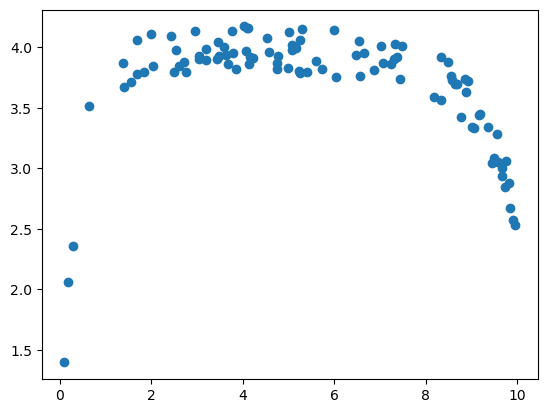

11:58: E221 multiple spaces before operator
11:80: E501 line too long (111 > 79 characters)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
# sns.set()

N = 100  # points to generate

X = np.sort(10*np.random.rand(N, 1)**0.8, axis=0)  # abscisses

y = 4 + 0.4*np.random.rand(N) - 1. / (X.ravel() + 0.5)**2  - 1. / (10.5 - X.ravel())  # some complicated function

plt.scatter(X, y)

Linear regression will obviously be a bad fit.

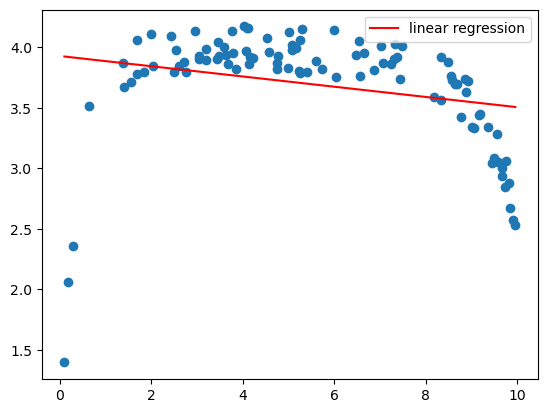

In [11]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(X, y)
plt.plot(X, yfit, color='r', label="linear regression")
plt.legend()

Let us transform it into a 3-degree polynomial fit and perform the same linear regression.

In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)  # 3 degree without degree 0 (no constant)
XPoly = poly.fit_transform(X)
print(XPoly[:5,])

3:80: E501 line too long (98 > 79 characters)


[[9.65631887e-02 9.32444941e-03 9.00398568e-04]
 [1.83631620e-01 3.37205719e-02 6.19216325e-03]
 [2.88344021e-01 8.31422742e-02 2.39735776e-02]
 [6.38214326e-01 4.07317526e-01 2.59955880e-01]
 [1.37722049e+00 1.89673628e+00 2.61222407e+00]]


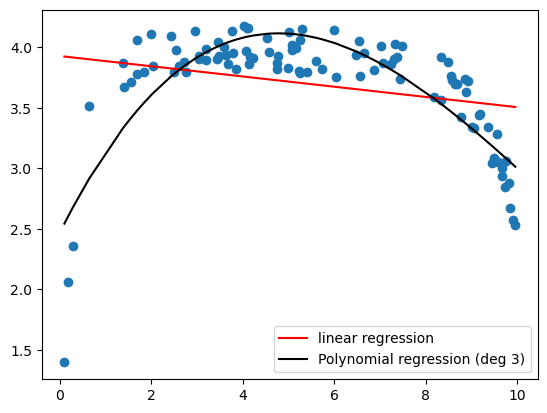

In [16]:
modelPoly = LinearRegression().fit(XPoly, y)
yfitPoly = modelPoly.predict(XPoly)
plt.scatter(X, y)
plt.plot(X, yfit, color='r', label="linear regression")
plt.plot(X, yfitPoly, color='k', label="Polynomial regression (deg 3)")
plt.legend(loc='lower right')

### Pipeline 

This *2-step* fitting (Polynomial transform + Linear regression) calls for a replicated dataset which can be costly. That is why Scikit Learn implement a *pipeline* method that allows to perform multiple fit/transform sequentially.

This pipeline can then be used as a model. 



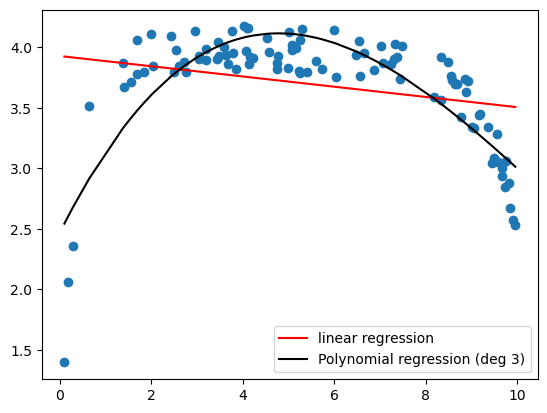

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

polyFeat = PolynomialFeatures(degree=3, include_bias=False)
linReg = LinearRegression()

polyReg = Pipeline([('polyFeat', polyFeat), ('linReg', linReg)])

polyReg.fit(X, y)  # X original not XPoly
yfitPolyNew = polyReg.predict(X)

plt.scatter(X, y)
plt.plot(X, yfit, color='r', label="linear regression")
plt.plot(X, yfitPolyNew, color='k', label="Polynomial regression (deg 3)")
plt.legend(loc='lower right')

## Validation and Hyperparameters tuning


We saw above (see the lasso example of the regression part) some basic examples of how to:
* *validate our model* by splitting the dataset into training and testing set (using `train_test_split`)
* *tune hyperparameter* by looking at the error for different values

Scikit Learn actually provides some methods for that as well.

### Validation

Scikit Learn offer a *cross validation* method that 
* split the dataset in several groups
* for each of these group, fit the model on all but this group and computer the error on this one

This way all the data has gone thought the learning and validating sets hence the *cross* validation. This is illustrated by the following figure from the  [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas.

![Cross validation](img/cv.png)

The score computer is computed either as the standard score of the estimator or can be precised with the <tt>scoring</tt> option (see the [available metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules) ). 

**Warning** All scorer objects follow the convention that higher return values are better than lower return values.


Let us compute the cross validation for our polynomial fit problem. 

In [22]:
from sklearn.model_selection import cross_val_score

cv_score = cross_val_score(polyReg, X, y, cv=5, scoring="neg_mean_absolute_error")  # 5 groups cross validation

print(cv_score)
print("Mean score:", np.mean(cv_score))

3:80: E501 line too long (111 > 79 characters)


[-1.20731107 -0.12868764 -0.2602563  -0.31772295 -0.90784021]
Mean score: -0.5643636336861668


### Grid Search

Now that scoring and cross validation is done, we can focus on investigating the best parameters of our polynomial model:
* degree
* presence or not of an intercept

Let us see which are the parameters of our model (as this is a pipeline, this might be interesting to use the <tt>get_params</tt> function).

In [23]:
polyReg.get_params()

{'memory': None,
 'steps': [('polyFeat', PolynomialFeatures(degree=3, include_bias=False)),
  ('linReg', LinearRegression())],
 'verbose': False,
 'polyFeat': PolynomialFeatures(degree=3, include_bias=False),
 'linReg': LinearRegression(),
 'polyFeat__degree': 3,
 'polyFeat__include_bias': False,
 'polyFeat__interaction_only': False,
 'polyFeat__order': 'C',
 'linReg__copy_X': True,
 'linReg__fit_intercept': True,
 'linReg__n_jobs': None,
 'linReg__positive': False}

This enables to see the parameters corresponding to the quantities to fit:
* degree: `polyFeat__degree`
* presence or not of an intercept: `linReg__fit_intercept`  and `polyFeat__include_bias`

We can now construct a *dictionary* of values to test.

In [25]:
param_grid = [
  {'polyFeat__degree':  np.arange(1, 12),
   'linReg__fit_intercept': [True, False],
   'polyFeat__include_bias': [True, False]}]

In [27]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(polyReg, param_grid, cv=5)
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polyFeat',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('linReg', LinearRegression())]),
             param_grid=[{'linReg__fit_intercept': [True, False],
                          'polyFeat__degree': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
                          'polyFeat__include_bias': [True, False]}])

We can then get the best parameters and the corresponding model.

In [28]:
grid.best_params_

{'linReg__fit_intercept': True,
 'polyFeat__degree': 4,
 'polyFeat__include_bias': True}

Text(0.5, 1.0, 'Best and overfitted models')

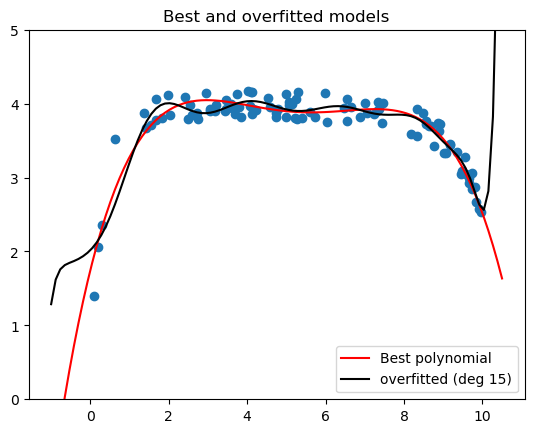

In [34]:
best_model = grid.best_estimator_.fit(X, y)
overfit = polyReg.set_params(polyFeat__degree=15).fit(X, y)

Xplot = np.linspace(-1, 10.5, 100).reshape(-1, 1)
yBest = best_model.predict(Xplot)
yOver = overfit.predict(Xplot)

plt.scatter(X, y)
plt.plot(Xplot, yBest, 'r', label="Best polynomial")
plt.plot(Xplot, yOver, 'k', label="overfitted (deg 15)")
plt.legend(loc='lower right')
plt.ylim([0, 5])
plt.title("Best and overfitted models")

We notice that the grid search based on cross validation helped discarded overfitted models (as they were bad on validation sets).

## Text and Image Features


We already saw an example of feature extraction from categorical data. However, for some particular categorical data, dedicated tools exist. For instance, text and images.


### Text feature extraction


In Learning applications, words are usually more important than letters, so a basic way to extract features is to construct one feature per present word and count the occurences of this word. This is known as *word count*. An approach to mitigate very present words (like "the" , "a" , etc) is *term frequency inverse document frequency* (tf-idf) which weights the occurence count by how often it appears. 


In [36]:
f = open('./data/poems/poe-raven.txt', 'r')
poe = f.read().replace('\n', ' ').replace('.', '').replace(',', '').replace('-', '')
poe

'                                      1845                                    THE RAVEN                                by Edgar Allan Poe      Once upon a midnight dreary while I pondered weak and weary   Over many a quaint and curious volume of forgotten lore     While I nodded nearly napping suddenly there came a tapping    As of some one gently rapping rapping at my chamber door   "\'Tis some visitor" I muttered "tapping at my chamber door                 Only this and nothing more"      Ah distinctly I remember it was in the bleak December   And each separate dying ember wrought its ghost upon the floor     Eagerly I wished the morrow; vainly I had sought to borrow     From my books surcease of sorrow sorrow for the lost Lenore   For the rare and radiant maiden whom the angels name Lenore                 Nameless here for evermore      And the silken sad uncertain rustling of each purple curtain   Thrilled me filled me with fantastic terrors never felt before;     So that now to s

2:80: E501 line too long (84 > 79 characters)


In [37]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform([poe])
X

<1x438 sparse matrix of type '<class 'numpy.int64'>'
	with 438 stored elements in Compressed Sparse Row format>

The vectorizer has registered the feature names and outed a sparse matrix that can be converted to a Dataframe.

In [38]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

/Users/lancelot/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

The tf-idf verctorizer works the same way.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
X = vec.fit_transform([poe])
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

For more details, see the [text feature extraction doc](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) and [image feature extraction doc](http://scikit-learn.org/stable/modules/feature_extraction.html#image-feature-extraction) as well as [scikit image](http://scikit-image.org/).